# Texas Rate Inspector Overview
- toc: true
- branch: master
- badges: false
- comments: true
- author: Kevin Bird
- categories: [texas,rate]
- hide: false

In [1]:
#hide_input
import pandas as pd
import datetime
import calendar

## What's the Problem?

Currently Texas' rate selection process is heavily driven by the lowest cost for a typical user.  However, this limits the imagination of Retail Electricity Providers (REP) and ends up hurting residential customers by creating a single variable rate plan that every REP optimizes for.  We at the Problem Solvers Guild have a different way of measuring plans that utilizes a customers' true historical usage.  Now the question is, which of the 159 plans currently available in almost any zip code in Texas is right for an individual?

![](notebook_images/2021-09-19-Texas-Rate-Inspector/powertochoose.png "159 Plans found on PowerToChoose for 77095")

## What's the Solution?

The Problem Solvers Guild has developed a method to take any electric `rate plan` and apply an individual's `usage` to calculate a more accurate price-per-kilowatt than what is typically provided by REPs.  With this solution, we help residential customers identify plans they would have previously overlooked.

We grab usage by working with [Smart Meter Texas](https://www.smartmetertexas.com/aboutus).  A site that was created to allow residential customers to access their 15-minute usage data.  This site also allows customers to share this access with companies with just a few pieces of information.

All of the rate plans that we currently use come from [Power to Choose](powertochoose.org) which is a site where REPs are able to advertise their available rates to residential customers.  Each plan has an electricity facts label (EFL) that describes the plan in detail.  We use these EFLs to model different rate plans that are offered.  

Once we have all of this information, we combine the data and find the rate that would have given an individual the lowest price-per-kilowatt over the past year.  If this is something you are interested in knowing for yourself, [fill out our form](https://www.problemsolversguild.com/texas-power/#tpwhearbcdgomrevxrxpjuuavqkoqwqxkeuh) and we will run an analysis for you.  If you are a company that would like to use our library to create better rate plans or to drive your rate engine, feel free to contact us and we can find a solution based on your needs as well.  

## How does it work?

The Problem Solvers Guild is excited to introduce the Texas Rate Inspector.  This tool allows an individual to quickly simulate any rate with their historical usage.  Let me take you on a quick tour of how this tool works.  

Here are three rate plans to choose from.  
1. **Plan 1 (Flat Rate)** charges <span>$</span>0.119 per kWh plus a <span>$</span>9.95 monthly charge if your usage for that month is less than 1000 kWh.
1. **Plan 2 (Free Weekends)** charges <span>$</span>0.200 per kWh between 12:00 AM Monday to 7:00 PM Friday plus a <span>$</span>4.95 monthly charge.
1. **Plan 3 (Tiered Rate)** charges <span>$</span>0.089 per kWh between 0 and 1200 kWh of usage and <span>$</span>0.145 per kWh past that.  This plan also has a <span>$</span>9.95 monthly charge and a <span>$</span>30 credit if you use more than 800 kWh.  

Now that I've given you all the information you need, which of these plans is the best option for a residential customer in Texas?  

You can close your Excel sheet.  I will walk you through each of these scenarios and at the end, I will tell you which of these is the best plan for the user.

## Grabbing Historical Usage

First, we grab a user's usage.  If you are interested in providing your usage information to us, [fill out our form](https://www.problemsolversguild.com/texas-power/#tpwhearbcdgomrevxrxpjuuavqkoqwqxkeuh) and we will get access from Smart Meter Texas.

In [21]:
from rate_inspector.usage import *
start_date = pd.to_datetime(datetime.date(2021, 7, 1))
end_date = pd.to_datetime(datetime.date(2021, 7,31))
data = pd.read_csv('../assets/example_usage.csv', parse_dates=['USAGE_DATE'])
data = get_data(data, start_date, end_date)
july_usage_data = UsageComponent.from_historical_df(data)

Here is a single day of historical usage (96 15-minute intervals)

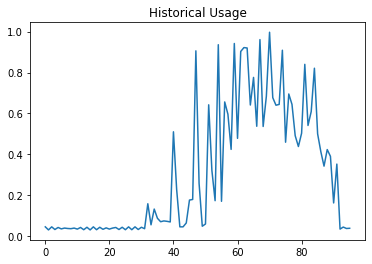

In [22]:
july_usage_data.plot_usage(0,96)

Now that we have historical usage, let's model each of the three plans. 

## Plan 1: Flat Rate
> Plan 1 (Flat Rate) charges <span>$</span>0.119 per kWh plus a <span>$</span>9.95 monthly charge if your usage for that month is less than 1000 kWh

In [23]:
from rate_inspector.rate import * 
from rate_inspector.plan import *

First, we identify the rate components.  This first plan has a `FlatThreshold` component that has a flat charge up to a threshold. 

In [5]:
base_w_peak = FlatThreshold('Flat Charge', 9.95, max_thresh=1000)
kwh_charge = TimeOfUseRate('Energy Charge', 0.119)

Once all of the rate components have been defined, we create a rate plan that contains all of the rate components.  

In [6]:
plan1 = RatePlan('Flat Rate', [base_w_peak, kwh_charge])

Next, we create a statement which combines the plan and the usage.

In [7]:
statement1 = Statement(plan1, july_usage_data)

Since total_usage was under 1000 kWh in this case, the &dollar;9.95 base charge is applied.

In [8]:
statement1.print_line_item()

Flat Charge: 9.9500
Energy Charge: 96.2753


In [9]:
statement1.total_usage

809.0359999999996

So our total cost per kwh is \$0.131/kWh for Plan 1

In [10]:
statement1.price_per_kwh

0.1312985874546989

## Plan 2: Free Weekends
> Plan 2 (Free Weekends) charges &dollar;0.200 per kWh between 12:00 AM Monday to 7:00 PM Friday plus a &dollar;4.95 monthly charge

In [11]:
energy_kwh_rest_of_week = TimeOfUseRate('RoW Energy Charge', 0.20, days_of_week=[calendar.MONDAY, calendar.TUESDAY, calendar.WEDNESDAY, calendar.THURSDAY])
energy_kwh_friday = TimeOfUseRate('Friday Energy Charge', 0.20, days_of_week=[calendar.FRIDAY], end_time=datetime.time(7))
base = Flat('Base Charge', 4.95)

In [12]:
plan2 = RatePlan('Free Weekends', [energy_kwh_rest_of_week, energy_kwh_friday, base])

In [13]:
statement2 = Statement(plan2, july_usage_data)

In [14]:
statement2.print_line_item()

RoW Energy Charge: 82.3296
Friday Energy Charge: 1.7952
Base Charge: 4.9500


So our total cost per kwh is \$0.11/kWh for Plan 2 even though the advertised price on PowerToChoose shows the minimum price per kWh to be \$0.132 (@ 2000 kWh)

In [15]:
statement2.price_per_kwh

0.11009992138792346

## Plan 3: Tiered Rate
> Plan 3 (Tiered Rate) charges \$0.089 per kWh between 0 and 1200 kWh of usage and \$0.145 per kWh past that. This plan also has a \$9.95 monthly charge and a \$30 credit if you use more than 800 kWh. 

In [16]:
base = Flat('Base Charge', 9.95)
tier1 = Tier('0-1200 kWh', 0.089, max_kwh=1200)
tier2 = Tier('> 1200 kWh', 0.145, min_kwh=1200)
credit = FlatThreshold('800 kwh credit', -30, min_thresh=800)

In [17]:
plan3 = RatePlan('Tiered Rate', [base, tier1, tier2, credit])

In [18]:
statement3 = Statement(plan3, july_usage_data)

In [19]:
statement3.print_line_item()

Base Charge: 9.9500
0-1200 kWh: 72.0042
> 1200 kWh: 0.0000
800 kwh credit: -30.0000


Plan 3 ends up being a great option for the usage.  Our user would have paid just \$0.064/kWh for plan number three.  One thing to keep in mind is that we are only simulating a single month at this point.  

In [20]:
statement3.price_per_kwh

0.06421741924957602

## Conclusion

This blog post shows an example of how the Texas Rate Inspector works.  If you are interested in getting your electric rates modeled or would like to hear more about what we do, [please reach out](https://www.problemsolversguild.com/texas-power/#tpwhearbcdgomrevxrxpjuuavqkoqwqxkeuh).  We would love to take your usage and help you find your next rate plan.